<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/microsoft/Florence_Large_to_onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Microsoft Florence (Multi Task Vision Model)

Florence-2 is an advanced vision foundation model that uses a prompt-based approach to handle a wide range of vision and vision-language tasks. Florence-2 can interpret simple text prompts to perform tasks like captioning, object detection, and segmentation. It leverages our FLD-5B dataset, containing 5.4 billion annotations across 126 million images, to master multi-task learning. The model's sequence-to-sequence architecture enables it to excel in both zero-shot and fine-tuned settings, proving to be a competitive vision foundation model.

***Florence-2-B model with 232 million parameters and Florence-2-L model with 771 million parameters.***

https://huggingface.co/collections/microsoft/florence-6669f44df0d87d9c3bfb76de

https://arxiv.org/pdf/2311.06242


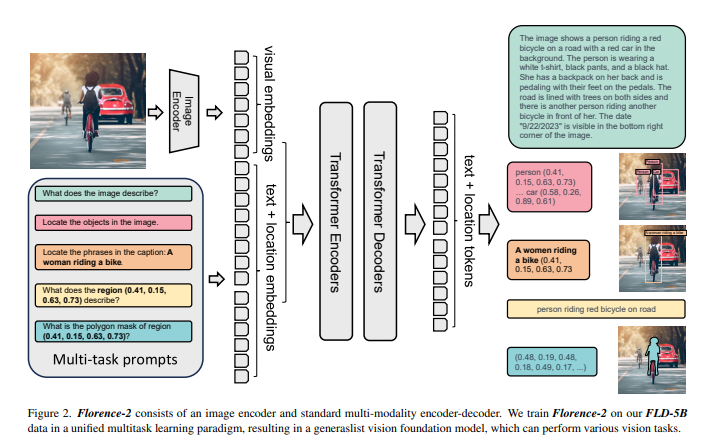

In [30]:
%pip install flash_attn einops timm mlflow pyngrok accelerate onnxruntime onnx --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 75.0 MB/s eta 0:00:00


In [40]:
import warnings

# Disable a few less-than-useful UserWarnings from setuptools and pydantic
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=Warning)

import matplotlib.pyplot as plt
import argparse
import imutils
import cv2
import numpy as np

In [58]:
import requests

from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM
import mlflow
import accelerate
import torch
import transformers
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [59]:
def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it\n
  try:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  except:
    image = image.convert('RGB')
  # show the image
  plt.imshow(image)
  plt.title(title)
  plt.grid(False)
  plt.show()

In [68]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

def run_example(task_prompt, text_input=None, image=image):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      early_stopping=False,
      max_new_tokens=1024,
      do_sample=False,
      num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))

    return parsed_answer

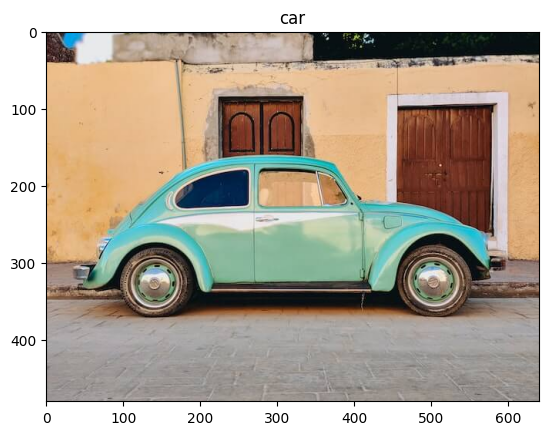

In [61]:
plt_imshow("car", image)

In [62]:
prompt = "<CAPTION>"
run_example(prompt)

{'<CAPTION>': 'A green car parked in front of a yellow building.'}

In [63]:
prompt = "<MORE_DETAILED_CAPTION>"
run_example(prompt)


{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a white stripe running along the side. It has two doors on either side of the car, one on top of the other, and a small window on the front. The building appears to be old and dilapidated, with peeling paint and crumbling walls. The sky is blue and there are trees in the background.'}

In [47]:
def load_img(path):
    image = Image.open(path).convert("RGB")
    image = image.resize((768, 768), Image.BILINEAR)
    img = np.array(image, dtype=np.float32)
    img /= 255.0
    img = np.transpose(img, (2, 0, 1))
    return img


In [66]:
img_path = '/content/drive/MyDrive/data/beach.jpg'
image2 = Image.open(img_path).convert("RGB")


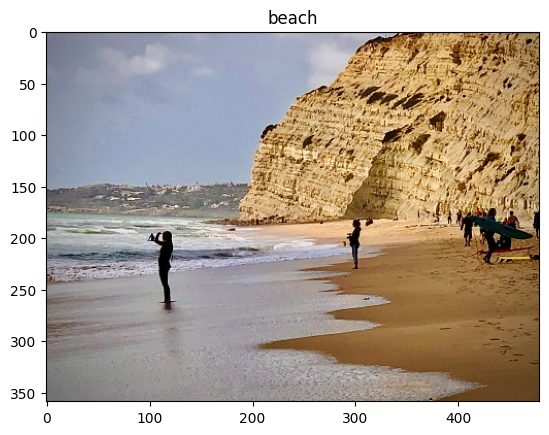

In [67]:
plt_imshow("beach", image2)

In [69]:
prompt = "<MORE_DETAILED_CAPTION>"
run_example(task_prompt=prompt, image=image2)

{'<MORE_DETAILED_CAPTION>': 'The image shows a sandy beach with a large cliff on the right side. The cliff is made of sandstone and has a rough, uneven surface. On the left side of the image, there is a body of water with small waves crashing onto the shore. In the foreground, there are several people walking on the beach, some of them carrying surfboards. The sky is blue and there are a few clouds in the sky. The beach appears to be empty, with no people visible in the image.'}

In [73]:
import torch
from transformers import AutoModel, AutoProcessor
from PIL import Image
import requests
import os
import onnxruntime as ort
import numpy as np

# Constants
MODEL_NAME = "amaye15/DaViT-Florence-2-large-ft"
CACHE_DIR = os.getcwd()
PROMPT ="<MORE_DETAILED_CAPTION>"
IMAGE_URL = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
ONNX_MODEL_PATH = "/content/drive/MyDrive/models/florence_large.onnx"

In [72]:

# Load the model and processor
model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True, cache_dir=CACHE_DIR)
processor = AutoProcessor.from_pretrained(MODEL_NAME, trust_remote_code=True, cache_dir=CACHE_DIR)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [74]:
# Prepare the input
image = Image.open(requests.get(IMAGE_URL, stream=True).raw)
inputs = processor(text=PROMPT, images=image, return_tensors="pt")

# Export the model to ONNX
input_names = ["pixel_values"]
output_names = ["output"]
torch.onnx.export(
    model,
    inputs["pixel_values"],
    ONNX_MODEL_PATH,
    input_names=input_names,
    output_names=output_names,
    dynamic_axes={"pixel_values": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)

In [75]:
# Load the ONNX model
ort_session = ort.InferenceSession(ONNX_MODEL_PATH)

# Prepare the inputs for ONNX model
ort_inputs = {"pixel_values": inputs["pixel_values"].numpy()}

# Run the ONNX model
ort_outs = ort_session.run(None, ort_inputs)

# Display the output
print(ort_outs)

[array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]
